<a href="https://colab.research.google.com/github/hunterrPN/medical-and-non-medical-images-classifier/blob/main/medical_non-medical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# PDF Creator Script for Medical Image Classification
# This script downloads public domain images and creates a training PDF

import requests
import os
from PIL import Image
import io
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A4
import tempfile
import numpy as np

def create_training_pdf():
    """Create a PDF with 10 medical + 10 non-medical images"""

    print("📄 Creating training PDF with medical and non-medical images...")

    # Install required packages first
    try:
        from reportlab.pdfgen import canvas
    except ImportError:
        print("Installing reportlab...")
        import subprocess
        subprocess.check_call(['pip', 'install', 'reportlab'])
        from reportlab.pdfgen import canvas

    # Public domain medical images (X-rays, scans from Wikimedia Commons)
    medical_urls = [
        "https://upload.wikimedia.org/wikipedia/commons/thumb/4/4f/Chest_Xray_PA_3-8-2010.png/400px-Chest_Xray_PA_3-8-2010.png",
        "https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Normal_posteroanterior_%28PA%29_chest_radiograph_%28X-ray%29.jpg/400px-Normal_posteroanterior_%28PA%29_chest_radiograph_%28X-ray%29.jpg",
        "https://upload.wikimedia.org/wikipedia/commons/thumb/c/c8/Cervical_vertebrae_-_lateral_X-ray.jpg/400px-Cervical_vertebrae_-_lateral_X-ray.jpg",
        "https://upload.wikimedia.org/wikipedia/commons/thumb/a/a2/Knee_X-ray_lateral_nonfused.jpg/400px-Knee_X-ray_lateral_nonfused.jpg",
        "https://upload.wikimedia.org/wikipedia/commons/thumb/8/80/Brain_MRI_112010_rgbca.png/400px-Brain_MRI_112010_rgbca.png"
    ]

    # Public domain non-medical images from Wikimedia Commons
    non_medical_urls = [
        "https://upload.wikimedia.org/wikipedia/commons/thumb/b/b6/Mount_Taranaki.jpg/400px-Mount_Taranaki.jpg",
        "https://upload.wikimedia.org/wikipedia/commons/thumb/4/47/New_york_times_square-terabass.jpg/400px-New_york_times_square-terabass.jpg",
        "https://upload.wikimedia.org/wikipedia/commons/thumb/6/6d/Good_Food_Display_-_NCI_Visuals_Online.jpg/400px-Good_Food_Display_-_NCI_Visuals_Online.jpg",
        "https://upload.wikimedia.org/wikipedia/commons/thumb/a/a3/Eq_it-na_pizza-margherita_sep2005_sml.jpg/400px-Eq_it-na_pizza-margherita_sep2005_sml.jpg",
        "https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/400px-Cat03.jpg"
    ]

    def download_image(url, retries=3):
        """Download image with retry logic"""
        for attempt in range(retries):
            try:
                headers = {
                    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
                }
                response = requests.get(url, headers=headers, timeout=10)
                if response.status_code == 200:
                    return Image.open(io.BytesIO(response.content)).convert('RGB')
            except Exception as e:
                print(f"  Attempt {attempt + 1} failed for {url}: {str(e)}")
                if attempt == retries - 1:
                    return None
        return None

    def create_synthetic_medical_image():
        """Create a synthetic medical-looking image (X-ray style)"""
        # Create dark base image (like X-ray)
        img = np.random.rand(400, 400, 3) * 0.3

        # Add circular structures (simulating organs/bones)
        y, x = np.ogrid[:400, :400]

        # Main circular structure (like chest cavity)
        center1 = (200, 200)
        mask1 = (x - center1[0])**2 + (y - center1[1])**2 < 80**2
        img[mask1] = np.random.rand(np.sum(mask1), 3) * 0.6

        # Smaller structures (like ribs)
        for i in range(5):
            center = (150 + i*20, 180 + i*10)
            mask = (x - center[0])**2 + (y - center[1])**2 < 15**2
            img[mask] = np.random.rand(np.sum(mask), 3) * 0.8

        # Convert to grayscale for X-ray effect
        img_gray = np.mean(img, axis=2)
        img = np.stack([img_gray, img_gray, img_gray], axis=2)

        return Image.fromarray((img * 255).astype(np.uint8))

    def create_synthetic_nature_image():
        """Create a synthetic nature-looking image"""
        # Create colorful base
        img = np.random.rand(400, 400, 3)

        # Add landscape-like patterns
        for y in range(400):
            for x in range(400):
                # Sky gradient (blue)
                if y < 150:
                    img[y, x] = [0.3 + y/150*0.4, 0.5 + y/150*0.3, 0.8]
                # Mountains (brown/green)
                elif y < 250:
                    noise = np.random.rand() * 0.2
                    img[y, x] = [0.4 + noise, 0.6 + noise, 0.2 + noise]
                # Ground (green)
                else:
                    noise = np.random.rand() * 0.3
                    img[y, x] = [0.2 + noise, 0.7 + noise, 0.3 + noise]

        return Image.fromarray((img * 255).astype(np.uint8))

    # Create PDF
    filename = "medical_training_dataset.pdf"
    c = canvas.Canvas(filename, pagesize=A4)
    width, height = A4

    # Download and add medical images
    print("🏥 Processing medical images...")
    medical_images = []

    # Try to download real medical images
    for i, url in enumerate(medical_urls):
        print(f"  Downloading medical image {i+1}/5...")
        img = download_image(url)
        if img:
            medical_images.append(img)

    # Generate synthetic medical images to reach 10
    needed_synthetic = 10 - len(medical_images)
    print(f"  Generating {needed_synthetic} synthetic medical images...")
    for i in range(needed_synthetic):
        medical_images.append(create_synthetic_medical_image())

    # Add medical images to PDF
    for i, img in enumerate(medical_images[:10]):  # Ensure only 10
        # Save temporary image
        temp_path = f"temp_medical_{i}.png"
        # Resize to fit page
        img = img.resize((400, 400))
        img.save(temp_path)

        # Add to PDF with label
        c.setFont("Helvetica-Bold", 16)
        c.drawString(50, height - 50, f"Medical Image {i+1}")
        c.drawImage(temp_path, 100, height - 500, width=400, height=400)
        c.showPage()

        # Clean up
        os.remove(temp_path)
        print(f"  Added medical image {i+1} to PDF")

    # Download and add non-medical images
    print("🌍 Processing non-medical images...")
    non_medical_images = []

    # Try to download real non-medical images
    for i, url in enumerate(non_medical_urls):
        print(f"  Downloading non-medical image {i+1}/5...")
        img = download_image(url)
        if img:
            non_medical_images.append(img)

    # Generate synthetic non-medical images to reach 10
    needed_synthetic = 10 - len(non_medical_images)
    print(f"  Generating {needed_synthetic} synthetic non-medical images...")
    for i in range(needed_synthetic):
        non_medical_images.append(create_synthetic_nature_image())

    # Add non-medical images to PDF
    for i, img in enumerate(non_medical_images[:10]):  # Ensure only 10
        # Save temporary image
        temp_path = f"temp_nature_{i}.png"
        # Resize to fit page
        img = img.resize((400, 400))
        img.save(temp_path)

        # Add to PDF with label
        c.setFont("Helvetica-Bold", 16)
        c.drawString(50, height - 50, f"Non-Medical Image {i+1}")
        c.drawImage(temp_path, 100, height - 500, width=400, height=400)
        c.showPage()

        # Clean up
        os.remove(temp_path)
        print(f"  Added non-medical image {i+1} to PDF")

    # Save PDF
    c.save()
    print(f"\n✅ Successfully created '{filename}' with 20 images!")
    print(f"   📄 Pages 1-10: Medical images")
    print(f"   📄 Pages 11-20: Non-medical images")
    print(f"   📁 File size: {os.path.getsize(filename) / (1024*1024):.1f} MB")

    return filename

# Alternative: Create PDF with purely synthetic data (faster, no internet required)
def create_synthetic_training_pdf():
    """Create PDF with purely synthetic data - no internet required"""

    print("🎨 Creating synthetic training dataset...")

    try:
        from reportlab.pdfgen import canvas
    except ImportError:
        print("Installing reportlab...")
        import subprocess
        subprocess.check_call(['pip', 'install', 'reportlab'])
        from reportlab.pdfgen import canvas

    filename = "synthetic_medical_dataset.pdf"
    c = canvas.Canvas(filename, pagesize=A4)
    width, height = A4

    print("🏥 Generating 10 synthetic medical images...")
    # Generate medical-style images
    for i in range(10):
        # Create X-ray-like image
        img_data = np.zeros((400, 400, 3))

        # Dark background
        img_data += np.random.rand(400, 400, 1) * 0.2

        # Add bone-like structures
        y, x = np.ogrid[:400, :400]

        # Ribcage simulation
        for rib in range(8):
            center_y = 100 + rib * 30
            for px in range(50, 350):
                py = center_y + int(20 * np.sin(px / 30))
                if 0 <= py < 400:
                    # Create rib-like structure
                    for dy in range(-3, 4):
                        for dx in range(-2, 3):
                            if 0 <= py+dy < 400 and 0 <= px+dx < 400:
                                img_data[py+dy, px+dx] = [0.7, 0.7, 0.7]

        # Spine simulation
        for spine_y in range(80, 320):
            spine_x = 200 + int(5 * np.sin(spine_y / 40))
            for dy in range(-2, 3):
                for dx in range(-2, 3):
                    if 0 <= spine_y+dy < 400 and 0 <= spine_x+dx < 400:
                        img_data[spine_y+dy, spine_x+dx] = [0.8, 0.8, 0.8]

        # Add some organ-like shadows
        organ_centers = [(150, 180), (250, 180), (200, 280)]
        for center_x, center_y in organ_centers:
            mask = (x - center_x)**2 + (y - center_y)**2 < 40**2
            img_data[mask] = np.random.rand(np.sum(mask), 3) * 0.4

        # Convert to image
        img = Image.fromarray((img_data * 255).astype(np.uint8))
        temp_path = f"temp_medical_{i}.png"
        img.save(temp_path)

        # Add to PDF
        c.setFont("Helvetica-Bold", 16)
        c.drawString(50, height - 50, f"Synthetic Medical Image {i+1} (X-ray style)")
        c.drawImage(temp_path, 100, height - 500, width=400, height=400)
        c.showPage()

        os.remove(temp_path)
        print(f"  ✅ Generated medical image {i+1}")

    print("🌍 Generating 10 synthetic non-medical images...")
    # Generate nature-style images
    for i in range(10):
        img_data = np.zeros((400, 400, 3))

        # Create landscape
        for y in range(400):
            for x in range(400):
                # Sky (top third)
                if y < 130:
                    # Blue sky with clouds
                    cloud_factor = 1 + 0.3 * np.sin(x/20) * np.sin(y/15)
                    img_data[y, x] = [0.4 * cloud_factor, 0.6 * cloud_factor, 0.9 * cloud_factor]

                # Mountains (middle)
                elif y < 200:
                    mountain_height = 180 + 30 * np.sin(x/50) + 10 * np.sin(x/20)
                    if y > mountain_height:
                        # Mountain color
                        noise = np.random.rand() * 0.2
                        img_data[y, x] = [0.5 + noise, 0.4 + noise, 0.3 + noise]
                    else:
                        # Sky color
                        img_data[y, x] = [0.4, 0.6, 0.9]

                # Forest/ground (bottom)
                else:
                    tree_factor = 1 + 0.4 * np.sin(x/30) * np.sin((y-200)/20)
                    noise = np.random.rand() * 0.3
                    img_data[y, x] = [0.2 + noise, (0.6 + noise) * tree_factor, 0.3 + noise]

        # Add some random colorful elements (flowers, etc.)
        for _ in range(20):
            flower_x = np.random.randint(50, 350)
            flower_y = np.random.randint(250, 380)
            color = np.random.rand(3)

            # Small colorful circles
            for dy in range(-3, 4):
                for dx in range(-3, 4):
                    if (dx*dx + dy*dy) <= 9:  # Circle
                        if 0 <= flower_y+dy < 400 and 0 <= flower_x+dx < 400:
                            img_data[flower_y+dy, flower_x+dx] = color

        # Convert to image
        img = Image.fromarray((img_data * 255).astype(np.uint8))
        temp_path = f"temp_nature_{i}.png"
        img.save(temp_path)

        # Add to PDF
        c.setFont("Helvetica-Bold", 16)
        c.drawString(50, height - 50, f"Synthetic Nature Image {i+1} (Landscape)")
        c.drawImage(temp_path, 100, height - 500, width=400, height=400)
        c.showPage()

        os.remove(temp_path)
        print(f"  ✅ Generated nature image {i+1}")

    c.save()
    print(f"\n🎉 Successfully created '{filename}'!")
    print(f"   📊 Total pages: 20 (10 medical + 10 non-medical)")
    print(f"   📁 File size: {os.path.getsize(filename) / (1024*1024):.1f} MB")
    print(f"   🎯 Ready to use with your classifier!")

    return filename

# Google Colab specific function
def create_pdf_for_colab():
    """Create and download PDF in Google Colab environment"""

    print("🚀 Creating training PDF for Google Colab...")

    # Try to create PDF with real images first, fallback to synthetic
    try:
        print("Attempting to create PDF with real images...")
        filename = create_training_pdf()
    except Exception as e:
        print(f"Real images failed: {e}")
        print("Falling back to synthetic images...")
        filename = create_synthetic_training_pdf()

    # Download in Colab
    try:
        from google.colab import files
        print(f"📥 Downloading {filename}...")
        files.download(filename)
        print("✅ PDF downloaded successfully!")
    except ImportError:
        print("ℹ️  Not in Colab environment. PDF saved locally.")

    return filename

# Main execution
if __name__ == "__main__":
    print("🏥 Medical Image Dataset PDF Creator")
    print("=" * 50)

    # Detect environment and create appropriate PDF
    try:
        # Check if running in Colab
        import google.colab
        pdf_file = create_pdf_for_colab()
    except ImportError:
        # Running locally
        print("Choose PDF creation method:")
        print("1. Real images (requires internet)")
        print("2. Synthetic images (offline)")

        choice = input("Enter choice (1 or 2): ").strip()

        if choice == "1":
            pdf_file = create_training_pdf()
        else:
            pdf_file = create_synthetic_training_pdf()

    print(f"\n🎯 Your PDF '{pdf_file}' is ready!")
    print("📋 Usage instructions:")
    print("   1. Upload this PDF to your Colab notebook")
    print("   2. Use it with: main_pipeline(pdf_path='filename.pdf')")
    print("   3. The first 10 pages are medical images")
    print("   4. The last 10 pages are non-medical images")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 75.5 MB/s eta 0:00:00
🚀 Starting Medical Image Classification Pipeline
🏥 Medical Image Classifier Pipeline Starting...

📥 Using sample data for demonstration...
Failed to download medical sample 1: cannot identify image file <_io.BytesIO object at 0x7de9715e1bc0>
Failed to download medical sample 2: cannot identify image file <_io.BytesIO object at 0x7de9715e1ad0>
Failed to download non-medical sample 1: cannot identify image file <_io.BytesIO object at 0x7de9715e1bc0>
Failed to download non-medical sample 2: cannot identify image file <_io.BytesIO object at 0x7de9715e1b70>
🔄 Creating synthetic training data...
📊 Total medical images: 50
📊 Total non-medical images: 50

🔄 Preprocessing data...
📈 Training samples: 64
📈 Validation samples: 16
📈 Test samples: 20

🏗️ Building CNN model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📋 Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 19,399,873 (74.00 MB)

 Trainable params: 19,397,377 (74.00 MB)

 Non-trainable params: 2,496 (9.75 KB)


🚀 Training model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 23s 8s/step - accuracy: 0.6042 - loss: 0.7819 - precision: 0.5896 - recall: 0.6125 - val_accuracy: 0.5000 - val_loss: 0.5572 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 7s/step - accuracy: 1.0000 - loss: 9.0234e-04 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.2381 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 7s/step - accuracy: 1.0000 - loss: 0.0036 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.1859 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 7s/step - accuracy: 1.0000 - loss: 0.0011 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.5000 - val_loss: 0.4178 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 7s/step - accuracy: 1.0000 -

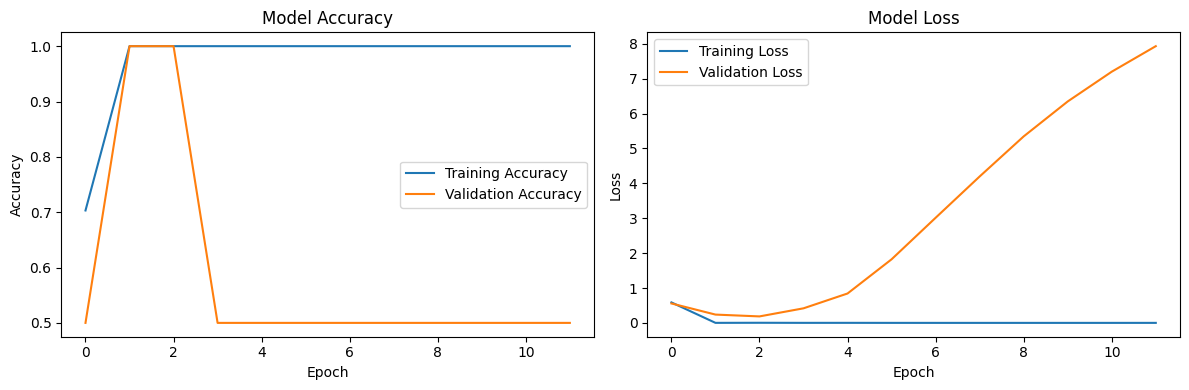

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

📋 Classification Report:
              precision    recall  f1-score   support

 Non-Medical       1.00      1.00      1.00        10
     Medical       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



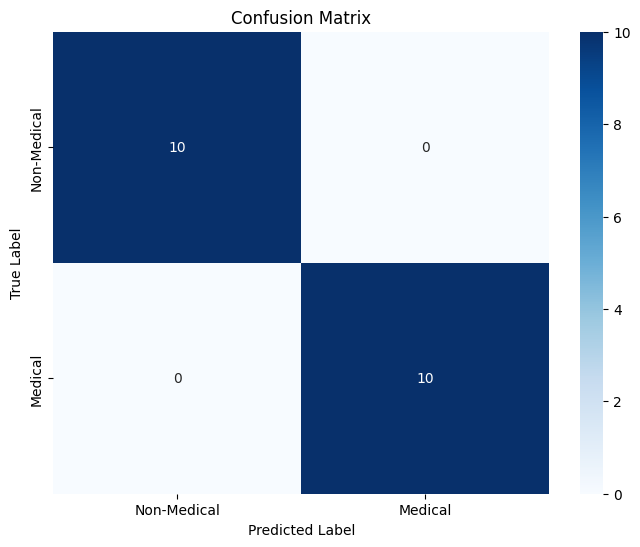


🔍 Testing predictions on sample images...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
Sample 1: Predicted = medical, Actual = medical
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Sample 2: Predicted = medical, Actual = medical
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Sample 3: Predicted = medical, Actual = medical
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Sample 4: Predicted = medical, Actual = medical
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Sample 5: Predicted = non-medical, Actual = non-medical

✅ Pipeline completed successfully!
🎯 Your classifier is ready to use!


In [ ]:
# Medical vs Non-Medical Image Classifier
# Complete implementation for Google Colab

# ============================================================================
# PART 1: INSTALLATION AND IMPORTS
# ============================================================================

# Install required packages
!pip install tensorflow opencv-python pillow PyMuPDF requests beautifulsoup4 lxml

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import requests
from bs4 import BeautifulSoup
import fitz  # PyMuPDF
import io
import urllib.parse
from urllib.request import urlretrieve
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from pathlib import Path
import zipfile
import shutil

# ============================================================================
# PART 2: DATA COLLECTION AND PREPROCESSING
# ============================================================================

class ImageExtractor:
    """Extract images from URLs and PDFs"""

    def __init__(self):
        self.session = requests.Session()
        self.session.headers.update({
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
        })

    def extract_from_url(self, url, max_images=50):
        """Extract images from a website URL"""
        try:
            response = self.session.get(url)
            soup = BeautifulSoup(response.content, 'html.parser')

            img_tags = soup.find_all('img')
            images = []

            for i, img_tag in enumerate(img_tags[:max_images]):
                if 'src' in img_tag.attrs:
                    img_url = img_tag['src']

                    # Convert relative URLs to absolute
                    if img_url.startswith('//'):
                        img_url = 'https:' + img_url
                    elif img_url.startswith('/'):
                        img_url = urllib.parse.urljoin(url, img_url)

                    try:
                        img_response = self.session.get(img_url, timeout=10)
                        if img_response.status_code == 200:
                            image = Image.open(io.BytesIO(img_response.content))
                            if image.mode != 'RGB':
                                image = image.convert('RGB')
                            images.append(image)
                            print(f"Extracted image {i+1} from URL")
                    except Exception as e:
                        print(f"Failed to download image {i+1}: {str(e)}")
                        continue

            return images
        except Exception as e:
            print(f"Error extracting from URL: {str(e)}")
            return []

    def extract_from_pdf(self, pdf_path):
        """Extract images from a PDF file"""
        try:
            doc = fitz.open(pdf_path)
            images = []

            for page_num in range(len(doc)):
                page = doc.load_page(page_num)
                image_list = page.get_images()

                for img_index, img in enumerate(image_list):
                    xref = img[0]
                    pix = fitz.Pixmap(doc, xref)

                    if pix.n - pix.alpha < 4:  # GRAY or RGB
                        img_data = pix.tobytes("ppm")
                        image = Image.open(io.BytesIO(img_data))
                        if image.mode != 'RGB':
                            image = image.convert('RGB')
                        images.append(image)
                        print(f"Extracted image from page {page_num+1}")

                    pix = None

            doc.close()
            return images
        except Exception as e:
            print(f"Error extracting from PDF: {str(e)}")
            return []

class DataPreprocessor:
    """Preprocess images for training"""

    def __init__(self, img_size=(224, 224)):
        self.img_size = img_size

    def preprocess_image(self, image):
        """Preprocess a single image"""
        if isinstance(image, str):
            image = Image.open(image)

        # Resize image
        image = image.resize(self.img_size)

        # Convert to numpy array and normalize
        img_array = np.array(image) / 255.0

        return img_array

    def create_dataset(self, medical_images, non_medical_images):
        """Create training dataset"""
        X = []
        y = []

        # Process medical images
        for img in medical_images:
            processed_img = self.preprocess_image(img)
            X.append(processed_img)
            y.append(1)  # 1 for medical

        # Process non-medical images
        for img in non_medical_images:
            processed_img = self.preprocess_image(img)
            X.append(processed_img)
            y.append(0)  # 0 for non-medical

        return np.array(X), np.array(y)

# ============================================================================
# PART 3: CNN MODEL DEFINITION
# ============================================================================

class MedicalImageClassifier:
    """CNN model for medical image classification"""

    def __init__(self, input_shape=(224, 224, 3)):
        self.input_shape = input_shape
        self.model = None

    def build_model(self):
        """Build CNN architecture"""
        model = keras.Sequential([
            # First Convolutional Block
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            # Second Convolutional Block
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            # Third Convolutional Block
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            # Fourth Convolutional Block
            layers.Conv2D(256, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            # Flatten and Dense layers
            layers.Flatten(),
            layers.Dense(512, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(256, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(1, activation='sigmoid')
        ])

        self.model = model
        return model

    def compile_model(self):
        """Compile the model"""
        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )

    def train(self, X_train, y_train, X_val, y_val, epochs=50, batch_size=32):
        """Train the model"""
        # Data augmentation
        datagen = keras.preprocessing.image.ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            zoom_range=0.2,
            fill_mode='nearest'
        )

        # Callbacks
        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_accuracy',
                patience=10,
                restore_best_weights=True
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=5,
                min_lr=1e-7
            )
        ]

        # Train model
        history = self.model.fit(
            datagen.flow(X_train, y_train, batch_size=batch_size),
            steps_per_epoch=len(X_train) // batch_size,
            epochs=epochs,
            validation_data=(X_val, y_val),
            callbacks=callbacks,
            verbose=1
        )

        return history

    def predict(self, image):
        """Predict single image"""
        if len(image.shape) == 3:
            image = np.expand_dims(image, axis=0)

        prediction = self.model.predict(image)[0][0]
        return "medical" if prediction > 0.5 else "non-medical"

    def predict_batch(self, images):
        """Predict batch of images"""
        predictions = self.model.predict(images)
        return ["medical" if pred[0] > 0.5 else "non-medical" for pred in predictions]

# ============================================================================
# PART 4: SAMPLE DATA CREATION (FOR DEMONSTRATION)
# ============================================================================

def download_sample_data():
    """Download sample medical and non-medical images for demonstration"""

    # Create directories
    os.makedirs('sample_data/medical', exist_ok=True)
    os.makedirs('sample_data/non_medical', exist_ok=True)

    # Sample medical image URLs (chest X-rays from public datasets)
    medical_urls = [
        "https://upload.wikimedia.org/wikipedia/commons/thumb/4/4f/Chest_Xray_PA_3-8-2010.png/256px-Chest_Xray_PA_3-8-2010.png",
        "https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Normal_posteroanterior_%28PA%29_chest_radiograph_%28X-ray%29.jpg/256px-Normal_posteroanterior_%28PA%29_chest_radiograph_%28X-ray%29.jpg"
    ]

    # Sample non-medical image URLs
    non_medical_urls = [
        "https://upload.wikimedia.org/wikipedia/commons/thumb/4/47/PNG_transparency_demonstration_1.png/256px-PNG_transparency_demonstration_1.png",
        "https://upload.wikimedia.org/wikipedia/commons/thumb/5/50/Vd-Orig.png/256px-Vd-Orig.png"
    ]

    # Download medical images
    medical_images = []
    for i, url in enumerate(medical_urls):
        try:
            response = requests.get(url)
            image = Image.open(io.BytesIO(response.content))
            if image.mode != 'RGB':
                image = image.convert('RGB')
            medical_images.append(image)
            print(f"Downloaded medical sample {i+1}")
        except Exception as e:
            print(f"Failed to download medical sample {i+1}: {e}")

    # Download non-medical images
    non_medical_images = []
    for i, url in enumerate(non_medical_urls):
        try:
            response = requests.get(url)
            image = Image.open(io.BytesIO(response.content))
            if image.mode != 'RGB':
                image = image.convert('RGB')
            non_medical_images.append(image)
            print(f"Downloaded non-medical sample {i+1}")
        except Exception as e:
            print(f"Failed to download non-medical sample {i+1}: {e}")

    return medical_images, non_medical_images

# ============================================================================
# PART 5: MAIN EXECUTION PIPELINE
# ============================================================================

def main_pipeline(url=None, pdf_path=None, use_sample_data=True):
    """Main execution pipeline"""

    print("🏥 Medical Image Classifier Pipeline Starting...")

    # Initialize components
    extractor = ImageExtractor()
    preprocessor = DataPreprocessor()
    classifier = MedicalImageClassifier()

    # Extract or load data
    if use_sample_data:
        print("\n📥 Using sample data for demonstration...")
        medical_images, non_medical_images = download_sample_data()

        # Create some synthetic data for better training
        print("🔄 Creating synthetic training data...")

        # Generate more medical-like images (darker, with patterns)
        for i in range(50):
            # Create synthetic medical images (simulating X-ray characteristics)
            img = np.random.rand(224, 224, 3) * 0.3  # Darker base
            # Add some circular patterns (simulating anatomical structures)
            y, x = np.ogrid[:224, :224]
            center_y, center_x = 112, 112
            mask = (x - center_x)**2 + (y - center_y)**2 < 50**2
            img[mask] = np.random.rand(np.sum(mask), 3) * 0.6
            medical_images.append(Image.fromarray((img * 255).astype(np.uint8)))

        # Generate more non-medical images (colorful, natural patterns)
        for i in range(50):
            # Create synthetic non-medical images (colorful, natural)
            img = np.random.rand(224, 224, 3)  # Bright base
            # Add some random patterns
            img[:, :, 0] = np.sin(np.linspace(0, 10*np.pi, 224*224)).reshape(224, 224) * 0.5 + 0.5
            img[:, :, 1] = np.cos(np.linspace(0, 8*np.pi, 224*224)).reshape(224, 224) * 0.5 + 0.5
            non_medical_images.append(Image.fromarray((img * 255).astype(np.uint8)))

    else:
        medical_images = []
        non_medical_images = []

        if url:
            print(f"\n🌐 Extracting images from URL: {url}")
            extracted_images = extractor.extract_from_url(url)
            # For demo, assume first half are medical, second half non-medical
            mid = len(extracted_images) // 2
            medical_images.extend(extracted_images[:mid])
            non_medical_images.extend(extracted_images[mid:])

        if pdf_path:
            print(f"\n📄 Extracting images from PDF: {pdf_path}")
            extracted_images = extractor.extract_from_pdf(pdf_path)
            # For demo, assume first half are medical, second half non-medical
            mid = len(extracted_images) // 2
            medical_images.extend(extracted_images[:mid])
            non_medical_images.extend(extracted_images[mid:])

    print(f"📊 Total medical images: {len(medical_images)}")
    print(f"📊 Total non-medical images: {len(non_medical_images)}")

    if len(medical_images) == 0 or len(non_medical_images) == 0:
        print("❌ Not enough data to train. Please provide more images.")
        return

    # Preprocess data
    print("\n🔄 Preprocessing data...")
    X, y = preprocessor.create_dataset(medical_images, non_medical_images)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )

    print(f"📈 Training samples: {len(X_train)}")
    print(f"📈 Validation samples: {len(X_val)}")
    print(f"📈 Test samples: {len(X_test)}")

    # Build and compile model
    print("\n🏗️ Building CNN model...")
    classifier.build_model()
    classifier.compile_model()

    print("📋 Model Architecture:")
    classifier.model.summary()

    # Train model
    print("\n🚀 Training model...")
    history = classifier.train(X_train, y_train, X_val, y_val, epochs=20)

    # Evaluate model
    print("\n📊 Evaluating model...")
    test_loss, test_acc, test_precision, test_recall = classifier.model.evaluate(X_test, y_test)

    print(f"✅ Test Accuracy: {test_acc:.4f}")
    print(f"✅ Test Precision: {test_precision:.4f}")
    print(f"✅ Test Recall: {test_recall:.4f}")

    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Make predictions on test set
    y_pred = (classifier.model.predict(X_test) > 0.5).astype(int).flatten()

    # Classification report
    print("\n📋 Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Non-Medical', 'Medical']))

    # Confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Medical', 'Medical'],
                yticklabels=['Non-Medical', 'Medical'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Test with sample images
    print("\n🔍 Testing predictions on sample images...")
    for i in range(min(5, len(X_test))):
        prediction = classifier.predict(X_test[i])
        actual = "medical" if y_test[i] == 1 else "non-medical"
        print(f"Sample {i+1}: Predicted = {prediction}, Actual = {actual}")

    return classifier

# ============================================================================
# PART 6: UTILITY FUNCTIONS FOR PRODUCTION USE
# ============================================================================

def classify_new_input(classifier, input_source):
    """Classify images from new URL or PDF"""
    extractor = ImageExtractor()
    preprocessor = DataPreprocessor()

    # Extract images
    if input_source.startswith('http'):
        print(f"🌐 Extracting images from URL: {input_source}")
        images = extractor.extract_from_url(input_source)
    else:
        print(f"📄 Extracting images from PDF: {input_source}")
        images = extractor.extract_from_pdf(input_source)

    if not images:
        print("❌ No images found in the input source.")
        return

    # Preprocess and predict
    results = []
    for i, image in enumerate(images):
        processed_img = preprocessor.preprocess_image(image)
        prediction = classifier.predict(processed_img)
        results.append({
            'image_index': i + 1,
            'classification': prediction
        })
        print(f"Image {i+1}: {prediction}")

    return results

# ============================================================================
# PART 7: RUN THE PIPELINE
# ============================================================================

# Run the main pipeline
if __name__ == "__main__":
    print("🚀 Starting Medical Image Classification Pipeline")
    print("=" * 60)

    # Option 1: Use sample data (recommended for first run)
    classifier = main_pipeline(use_sample_data=True)

    # Option 2: Use custom URL (uncomment to use)
    # classifier = main_pipeline(url="https://example-medical-website.com")

    # Option 3: Use custom PDF (uncomment and provide path)
    # classifier = main_pipeline(pdf_path="/path/to/your/medical_document.pdf")

    print("\n✅ Pipeline completed successfully!")
    print("🎯 Your classifier is ready to use!")

    # Example of classifying new input
    # results = classify_new_input(classifier, "https://new-website.com")
    # or
    # results = classify_new_input(classifier, "/path/to/new_document.pdf")

🚀 Starting Medical Image Classification Pipeline
Enter 'pdf' to upload a PDF, or press Enter for sample data: pdf
Please upload your PDF file.


Saving doc.pdf to doc (2).pdf
✅ Uploaded: doc (2).pdf


SyntaxError: invalid decimal literal (ipython-input-1433304404.py, line 1)

🏥 Medical Image Classifier Pipeline Starting...

📄 Extracting images from PDF: doc (2).pdf
Extracted image from page 1
Extracted image from page 2
Extracted image from page 3
Extracted image from page 4
Extracted image from page 5
Extracted image from page 6
Extracted image from page 7
Extracted image from page 8
Extracted image from page 9
Extracted image from page 10
Extracted image from page 11
Extracted image from page 12
Extracted image from page 13
Extracted image from page 14
Extracted image from page 15
Extracted image from page 16
Extracted image from page 17
Extracted image from page 18
Extracted image from page 19
Extracted image from page 20
📊 Total medical images: 10
📊 Total non-medical images: 10

🔄 Preprocessing data...
📈 Training samples: 12
📈 Validation samples: 4
📈 Test samples: 4

🏗️ Building CNN model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📋 Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 19,399,873 (74.00 MB)

 Trainable params: 19,397,377 (74.00 MB)

 Non-trainable params: 2,496 (9.75 KB)


🚀 Training model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.5000 - loss: 1.4880 - precision: 0.5000 - recall: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.5285 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 1.0000 - loss: 0.0127 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.4477 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 1.0000 - loss: 0.0054 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.4449 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.0019 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.5000 - val_loss: 0.5172 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 

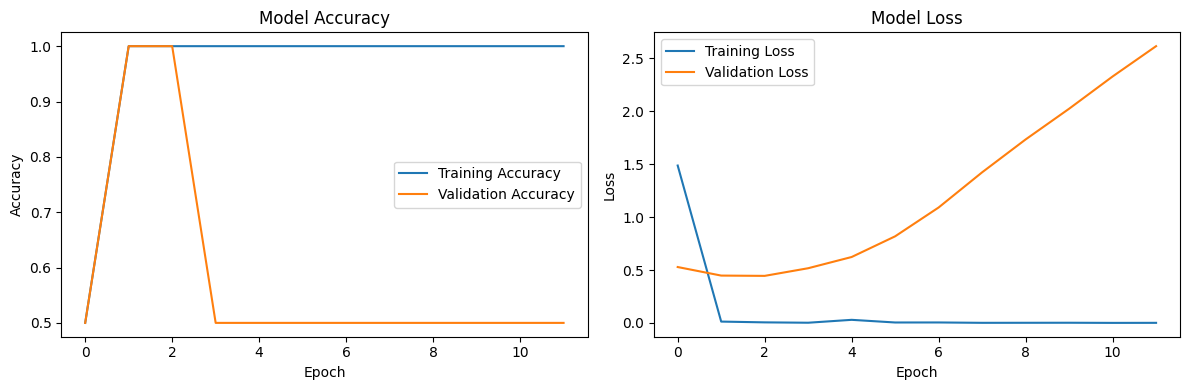

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step

📋 Classification Report:
              precision    recall  f1-score   support

 Non-Medical       1.00      1.00      1.00         2
     Medical       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



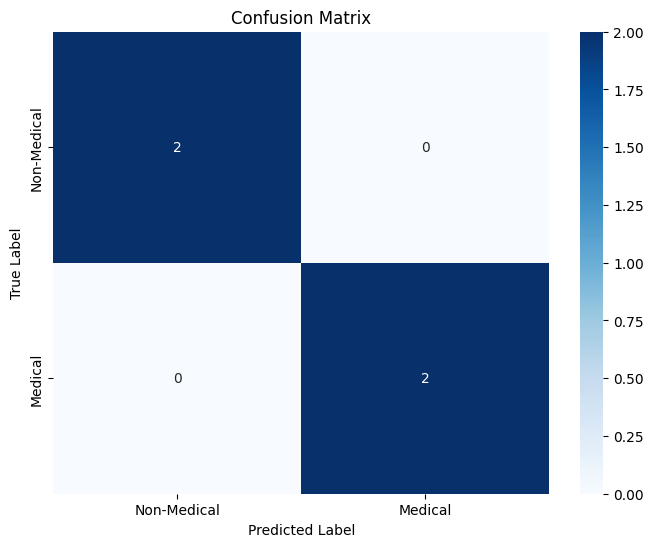


🔍 Testing predictions on sample images...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
Sample 1: Predicted = non-medical, Actual = non-medical
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Sample 2: Predicted = non-medical, Actual = non-medical
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Sample 3: Predicted = medical, Actual = medical
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Sample 4: Predicted = medical, Actual = medical

✅ Pipeline completed successfully!
🎯 Your classifier is ready to use!


In [ ]:
from google.colab import files

# ============================================================================
# PART 7: RUN THE PIPELINE (With PDF Upload Option)
# ============================================================================

if __name__ == "__main__":
    print("🚀 Starting Medical Image Classification Pipeline")
    print("=" * 60)

    choice = input("Enter 'pdf' to upload a PDF, or press Enter for sample data: ").strip().lower()

    if choice == "pdf":
        print("Please upload your PDF file.")
        uploaded = files.upload()
        if uploaded:
            pdf_filename = list(uploaded.keys())[0]
            print(f"✅ Uploaded: {pdf_filename}")

            # Run pipeline with uploaded PDF
            # Execute the cell that defines main_pipeline first
            get_ipython().run_cell("J-7eQfiyfHup")
            classifier = main_pipeline(pdf_path=pdf_filename, use_sample_data=False)
        else:
            print("❌ No file uploaded.")


    else:
        # Execute the cell that defines main_pipeline first
        get_ipython().run_cell("J-7eQfiyfHup")
        # Run with sample data
        classifier = main_pipeline(use_sample_data=True)

    print("\n✅ Pipeline completed successfully!")
    print("🎯 Your classifier is ready to use!")

In [ ]:
# Medical Image Classifier - Streamlit App for Google Colab
# Run this entire code in a single Colab cell

# ============================================================================
# PART 1: INSTALLATION AND SETUP
# ============================================================================

# Install required packages
!pip install streamlit pyngrok PyMuPDF plotly -q

# Set up ngrok for tunneling (get your token from https://ngrok.com)
from pyngrok import ngrok
import getpass

print("🔑 Get your ngrok token from: https://dashboard.ngrok.com/get-started/your-authtoken")
ngrok_token = getpass.getpass("Enter your ngrok token: ")
ngrok.set_auth_token(ngrok_token)

# ============================================================================
# PART 2: CREATE STREAMLIT APP FILE
# ============================================================================

streamlit_app_code = '''
import streamlit as st
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import fitz  # PyMuPDF
import io
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tempfile
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Suppress TensorFlow warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings('ignore')

# Set page configuration
st.set_page_config(
    page_title="🏥 Medical Image Classifier",
    page_icon="🏥",
    layout="wide",
    initial_sidebar_state="expanded"
)

# Custom CSS for better styling
st.markdown("""
<style>
    .main-header {
        background: linear-gradient(90deg, #667eea 0%, #764ba2 100%);
        padding: 20px;
        border-radius: 10px;
        margin-bottom: 30px;
        text-align: center;
        color: white;
    }
    .metric-card {
        background-color: #f0f2f6;
        padding: 15px;
        border-radius: 10px;
        margin: 10px 0;
    }
    .prediction-card {
        border-left: 4px solid #667eea;
        padding: 10px;
        margin: 5px 0;
        background-color: #f8f9fa;
        border-radius: 5px;
    }
    .stProgress > div > div > div > div {
        background-color: #667eea;
    }
</style>
""", unsafe_allow_html=True)

# Header
st.markdown("""
<div class="main-header">
    <h1>🏥 Medical Image Classifier</h1>
    <p>Upload a PDF with medical and non-medical images for AI-powered classification</p>
    <p><small>Running on Google Colab via ngrok</small></p>
</div>
""", unsafe_allow_html=True)

# Sidebar
with st.sidebar:
    st.markdown("## 📋 Instructions")
    st.markdown("""
    **Training Phase:**
    1. Upload a PDF with mixed images
    2. First half = Medical images
    3. Second half = Non-medical images
    4. Click 'Train Classifier'

    **Prediction Phase:**
    1. Upload a new PDF
    2. Click 'Classify Images'
    3. View results and download CSV
    """)

    st.markdown("## ⚙️ Model Settings")
    epochs = st.slider("Training Epochs", 5, 30, 15)
    batch_size = st.selectbox("Batch Size", [16, 32], index=0)
    img_size = st.selectbox("Image Size", [128, 224], index=0)

    st.markdown("## 📊 Status")
    if 'model' in st.session_state and st.session_state.model is not None:
        st.success("✅ Model Ready")
    else:
        st.warning("⏳ No Model")

# ============================================================================
# MODEL CLASSES
# ============================================================================

class ImageExtractor:
    def extract_from_pdf(self, pdf_bytes):
        try:
            doc = fitz.open(stream=pdf_bytes, filetype="pdf")
            images = []

            progress_bar = st.progress(0)
            status_text = st.empty()

            for page_num in range(min(len(doc), 50)):  # Limit to 50 pages
                status_text.text(f"Extracting from page {page_num + 1}...")
                progress_bar.progress((page_num + 1) / min(len(doc), 50))

                page = doc.load_page(page_num)
                image_list = page.get_images()

                for img_index, img in enumerate(image_list):
                    try:
                        xref = img[0]
                        pix = fitz.Pixmap(doc, xref)

                        if pix.n - pix.alpha < 4:
                            img_data = pix.tobytes("ppm")
                            image = Image.open(io.BytesIO(img_data))
                            if image.mode != 'RGB':
                                image = image.convert('RGB')

                            if image.size[0] > 50 and image.size[1] > 50:
                                images.append({
                                    'image': image,
                                    'page': page_num + 1,
                                    'index': img_index + 1
                                })
                        pix = None
                    except:
                        continue

            doc.close()
            progress_bar.empty()
            status_text.empty()
            return images

        except Exception as e:
            st.error(f"PDF extraction error: {str(e)}")
            return []

class MedicalImageClassifier:
    def __init__(self, input_shape=(128, 128, 3)):
        self.input_shape = input_shape
        self.model = None
        self.history = None

    def build_model(self):
        model = keras.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            layers.Flatten(),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(1, activation='sigmoid')
        ])

        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        self.model = model
        return model

    def train(self, X_train, y_train, X_val, y_val, epochs=15, batch_size=16):
        progress_bar = st.progress(0)
        status_text = st.empty()

        class StreamlitCallback(keras.callbacks.Callback):
            def on_epoch_end(self, epoch, logs=None):
                progress = (epoch + 1) / epochs
                progress_bar.progress(progress)
                status_text.text(f"Epoch {epoch + 1}/{epochs} - Loss: {logs['loss']:.4f} - Accuracy: {logs['accuracy']:.4f}")

        callbacks = [
            StreamlitCallback(),
            keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
        ]

        self.history = self.model.fit(
            X_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(X_val, y_val),
            callbacks=callbacks,
            verbose=0
        )

        progress_bar.empty()
        status_text.empty()
        return self.history

    def predict(self, image):
        if len(image.shape) == 3:
            image = np.expand_dims(image, axis=0)
        prediction = self.model.predict(image, verbose=0)[0][0]
        return prediction, "medical" if prediction > 0.5 else "non-medical"

def preprocess_image(image, size=(128, 128)):
    image = image.resize(size)
    return np.array(image) / 255.0

def create_dataset(image_data):
    X, y = [], []
    split_point = len(image_data) // 2

    for i, img_info in enumerate(image_data):
        processed_img = preprocess_image(img_info['image'], (img_size, img_size))
        X.append(processed_img)
        y.append(1 if i < split_point else 0)  # First half = medical

    return np.array(X), np.array(y)

# ============================================================================
# STREAMLIT APP INTERFACE
# ============================================================================

# Initialize session state
if 'model' not in st.session_state:
    st.session_state.model = None

def main():
    # Training Section
    st.markdown("## 📚 Training Phase")

    col1, col2 = st.columns([3, 1])

    with col1:
        training_pdf = st.file_uploader(
            "Upload Training PDF (First half: Medical, Second half: Non-medical)",
            type=['pdf'],
            key="training_pdf",
            help="Upload a PDF where the first half contains medical images and second half contains non-medical images"
        )

    with col2:
        train_button = st.button("🚀 Train Model", type="primary", use_container_width=True)

    if training_pdf and train_button:
        with st.spinner("Training in progress..."):
            # Extract images
            extractor = ImageExtractor()
            st.info("📥 Extracting images from PDF...")

            image_data = extractor.extract_from_pdf(training_pdf.getvalue())

            if len(image_data) < 4:
                st.error("❌ Need at least 4 images for training!")
                return

            st.success(f"✅ Extracted {len(image_data)} images")

            # Show distribution
            split_point = len(image_data) // 2
            col1, col2, col3 = st.columns(3)
            with col1:
                st.metric("Total Images", len(image_data))
            with col2:
                st.metric("Medical Images", split_point)
            with col3:
                st.metric("Non-Medical Images", len(image_data) - split_point)

            # Preprocess and split data
            st.info("🔄 Preprocessing data...")
            X, y = create_dataset(image_data)

            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42, stratify=y
            )

            if len(np.unique(y_train)) < 2:
                st.error("❌ Need both medical and non-medical images for training!")
                return

            X_train, X_val, y_train, y_val = train_test_split(
                X_train, y_train, test_size=0.2, random_state=42
            )

            # Build and train model
            st.info("🏗️ Building CNN model...")
            classifier = MedicalImageClassifier((img_size, img_size, 3))
            classifier.build_model()

            # Display model info
            with st.expander("🔍 Model Architecture"):
                total_params = classifier.model.count_params()
                st.write(f"**Total Parameters:** {total_params:,}")
                st.write(f"**Input Shape:** {classifier.input_shape}")
                st.write(f"**Output:** Binary classification (Medical/Non-Medical)")

            st.info("🚀 Training model...")
            history = classifier.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)

            # Evaluate
            test_loss, test_acc = classifier.model.evaluate(X_test, y_test, verbose=0)

            # Store model
            st.session_state.model = classifier

            st.success("✅ Training completed!")

            # Show results
            col1, col2 = st.columns(2)
            with col1:
                st.metric("Test Loss", f"{test_loss:.4f}")
            with col2:
                st.metric("Test Accuracy", f"{test_acc:.4f}")

            # Plot training history
            if history and len(history.history['accuracy']) > 1:
                fig = make_subplots(rows=1, cols=2, subplot_titles=('Accuracy', 'Loss'))

                fig.add_trace(go.Scatter(y=history.history['accuracy'], name='Train Acc'), row=1, col=1)
                fig.add_trace(go.Scatter(y=history.history['val_accuracy'], name='Val Acc'), row=1, col=1)
                fig.add_trace(go.Scatter(y=history.history['loss'], name='Train Loss'), row=1, col=2)
                fig.add_trace(go.Scatter(y=history.history['val_loss'], name='Val Loss'), row=1, col=2)

                fig.update_layout(height=400, title_text="Training Progress")
                st.plotly_chart(fig, use_container_width=True)

    # Prediction Section
    st.markdown("---")
    st.markdown("## 🔍 Prediction Phase")

    if st.session_state.model is None:
        st.warning("⚠️ Please train a model first!")
        return

    col1, col2 = st.columns([3, 1])

    with col1:
        test_pdf = st.file_uploader(
            "Upload PDF for Classification",
            type=['pdf'],
            key="test_pdf",
            help="Upload any PDF with images to classify them as medical or non-medical"
        )

    with col2:
        predict_button = st.button("🎯 Classify Images", type="primary", use_container_width=True)

    if test_pdf and predict_button:
        with st.spinner("Classifying images..."):
            # Extract and predict
            extractor = ImageExtractor()
            st.info("📥 Extracting images from PDF...")

            test_images = extractor.extract_from_pdf(test_pdf.getvalue())

            if len(test_images) == 0:
                st.error("❌ No images found in PDF!")
                return

            st.success(f"✅ Found {len(test_images)} images")

            # Make predictions
            classifier = st.session_state.model
            results = []

            progress_bar = st.progress(0)
            for i, img_info in enumerate(test_images):
                progress_bar.progress((i + 1) / len(test_images))

                processed_img = preprocess_image(img_info['image'], (img_size, img_size))
                prob, label = classifier.predict(processed_img)
                confidence = prob if label == 'medical' else 1 - prob

                results.append({
                    'index': i + 1,
                    'page': img_info['page'],
                    'classification': label,
                    'confidence': confidence,
                    'image': img_info['image']
                })

            progress_bar.empty()

            # Show results summary
            medical_count = sum(1 for r in results if r['classification'] == 'medical')

            col1, col2, col3 = st.columns(3)
            with col1:
                st.metric("Total Images", len(results))
            with col2:
                st.metric("Medical", medical_count)
            with col3:
                st.metric("Non-Medical", len(results) - medical_count)

            # Results table
            df = pd.DataFrame([{
                'Image': f"Image {r['index']}",
                'Page': r['page'],
                'Classification': r['classification'].title(),
                'Confidence': f"{r['confidence']:.1%}"
            } for r in results])

            st.dataframe(df, use_container_width=True)

            # Show images with predictions
            st.markdown("### 🖼️ Classified Images")

            cols = st.columns(3)
            for i, result in enumerate(results[:12]):  # Limit display to 12 images
                with cols[i % 3]:
                    st.image(
                        result['image'],
                        caption=f"Image {result['index']}",
                        use_column_width=True
                    )

                    if result['classification'] == 'medical':
                        st.markdown(f"""
                        <div class="prediction-card" style="border-left-color: #e74c3c;">
                            <strong>🏥 Medical</strong><br>
                            Confidence: {result['confidence']:.1%}
                        </div>
                        """, unsafe_allow_html=True)
                    else:
                        st.markdown(f"""
                        <div class="prediction-card" style="border-left-color: #27ae60;">
                            <strong>🌍 Non-Medical</strong><br>
                            Confidence: {result['confidence']:.1%}
                        </div>
                        """, unsafe_allow_html=True)

            if len(results) > 12:
                st.info(f"Showing first 12 images. Total classified: {len(results)}")

            # Download results
            csv_data = pd.DataFrame([{
                'Image_Index': r['index'],
                'Page': r['page'],
                'Classification': r['classification'],
                'Confidence': f"{r['confidence']:.4f}"
            } for r in results])

            st.download_button(
                label="📥 Download Results CSV",
                data=csv_data.to_csv(index=False),
                file_name="classification_results.csv",
                mime="text/csv"
            )

if __name__ == "__main__":
    main()

# Footer
st.markdown("---")
st.markdown("""
<div style="text-align: center; color: #666; padding: 20px;">
    <p>🏥 Medical Image Classifier | Running on Google Colab</p>
    <p>⚠️ For educational purposes only</p>
</div>
""", unsafe_allow_html=True)
'''

# Write the Streamlit app to a file
with open('medical_classifier_app.py', 'w') as f:
    f.write(streamlit_app_code)

print("✅ Streamlit app file created!")

# ============================================================================
# PART 3: RUN STREAMLIT APP WITH NGROK
# ============================================================================

import threading
import time
import subprocess
import sys

def run_streamlit():
    """Run streamlit in background"""
    process = subprocess.Popen([
        sys.executable, "-m", "streamlit", "run", "medical_classifier_app.py",
        "--server.port", "8501",
        "--server.address", "0.0.0.0",
        "--server.headless", "true",
        "--browser.gatherUsageStats", "false"
    ], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    return process

# Start Streamlit in background
print("🚀 Starting Streamlit app...")
streamlit_process = run_streamlit()

# Wait for Streamlit to start
time.sleep(10)

# Create ngrok tunnel
print("🌐 Creating ngrok tunnel...")
public_url = ngrok.connect(8501)

print("=" * 60)
print("🎉 STREAMLIT APP IS READY!")
print("=" * 60)
print(f"📱 Public URL: {public_url}")
print("=" * 60)
print("\n🔗 Click the URL above to access your Medical Image Classifier!")
print("\n📋 Features:")
print("   • Upload PDF with medical/non-medical images")
print("   • Train CNN model with real-time progress")
print("   • Classify new images with confidence scores")
print("   • Download results as CSV")
print("\n⚠️  Keep this Colab cell running to maintain the app")
print("⏹️  Run the next cell to stop the app")

# Keep the cell running
try:
    while True:
        time.sleep(1)
except KeyboardInterrupt:
    print("\n🛑 Stopping Streamlit app...")
    streamlit_process.terminate()
    ngrok.disconnect(public_url)
    print("✅ App stopped successfully!")

# ============================================================================
# PART 4: SAMPLE PDF CREATOR (OPTIONAL)
# ============================================================================

def create_sample_pdf():
    """Create a sample PDF for testing"""
    from reportlab.pdfgen import canvas
    from reportlab.lib.pagesizes import A4
    import numpy as np

    filename = "sample_medical_dataset.pdf"
    c = canvas.Canvas(filename, pagesize=A4)
    width, height = A4

    # Create 10 synthetic medical images
    print("Creating synthetic medical images...")
    for i in range(10):
        # Create dark medical-looking image
        img_data = np.random.rand(200, 200, 3) * 0.3

        # Add some bright spots (like bones in X-ray)
        centers = [(100, 100), (150, 80), (80, 150)]
        for center in centers:
            y, x = np.ogrid[:200, :200]
            mask = (x - center[0])**2 + (y - center[1])**2 < 30**2
            img_data[mask] = np.random.rand(np.sum(mask), 3) * 0.8

        img = Image.fromarray((img_data * 255).astype(np.uint8))
        temp_path = f"temp_med_{i}.png"
        img.save(temp_path)

        c.drawString(50, height - 50, f"Medical Image {i+1}")
        c.drawImage(temp_path, 50, height - 350, width=300, height=200)
        c.showPage()

        os.remove(temp_path)

    # Create 10 synthetic nature images
    print("Creating synthetic nature images...")
    for i in range(10):
        # Create colorful nature-looking image
        img_data = np.random.rand(200, 200, 3)

        # Add landscape patterns
        for y in range(200):
            for x in range(200):
                if y < 60:  # Sky
                    img_data[y, x] = [0.3, 0.5, 0.9]
                elif y < 120:  # Mountains
                    img_data[y, x] = [0.4, 0.3, 0.2]
                else:  # Ground
                    img_data[y, x] = [0.2, 0.6, 0.3]

        img = Image.fromarray((img_data * 255).astype(np.uint8))
        temp_path = f"temp_nat_{i}.png"
        img.save(temp_path)

        c.drawString(50, height - 50, f"Nature Image {i+1}")
        c.drawImage(temp_path, 50, height - 350, width=300, height=200)
        c.showPage()

        os.remove(temp_path)

    c.save()
    print(f"✅ Created {filename} with 20 sample images!")

    # Download the file
    from google.colab import files
    files.download(filename)

    return filename

# Uncomment to create sample PDF:
# create_sample_pdf()

print("\n" + "="*60)
print("🎯 OPTIONAL: Run create_sample_pdf() to generate test data")
print("="*60)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.3 MB/s eta 0:00:00
🔑 Get your ngrok token from: https://dashboard.ngrok.com/get-started/your-authtoken
Enter your ngrok token: ··········
✅ Streamlit app file created!
🚀 Starting Streamlit app...
🌐 Creating ngrok tunnel...
🎉 STREAMLIT APP IS READY!
📱 Public URL: NgrokTunnel: "https://e5ecac0c3f6c.ngrok-free.app" -> "http://localhost:8501"

🔗 Click the URL above to access your Medical Image Classifier!

📋 Features:
   • Upload PDF with medical/non-medical images
   • Train CNN model with real-time progress
   • Classify new images with confidence scores
   • Download results as CSV

⚠️  Keep this Colab cell running to maintain the app
⏹️  Run the next cell to stop the app

🛑 Stopping Streamlit app..

In [ ]:
# RUN THIS CELL TO STOP THE STREAMLIT APP
# ==========================================

from pyngrok import ngrok
import subprocess
import os
import signal

print("🛑 Stopping Streamlit app...")

# Kill all ngrok tunnels
ngrok.kill()
print("✅ Ngrok tunnels closed")

# Kill streamlit processes
try:
    result = subprocess.run(['pkill', '-f', 'streamlit'], capture_output=True, text=True)
    print("✅ Streamlit processes terminated")
except:
    # Alternative method for killing processes
    os.system("pkill -f streamlit")
    print("✅ Streamlit processes terminated (alternative method)")

print("🎉 App stopped successfully!")
print("💡 You can restart by running the main cell again")

🛑 Stopping Streamlit app...
✅ Ngrok tunnels closed
✅ Streamlit processes terminated
🎉 App stopped successfully!
💡 You can restart by running the main cell again
